In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import numpy as np

def generate_exploration_path(
    duration=60.0,
    dt=0.1,
    movement_magnitude=0.5,
    angular_std=0.33,
    boundaries=np.array([[-1, 1], [-1, 1], [-1, 1]]),
    start_position=None,
    drift_strength=0.0
):
    """
    Generate a 3D random explorational path using smooth angular random walk.
    
    Parameters
    ----------
    duration : float
        Total duration of the trajectory in seconds (default: 60.0)
    dt : float
        Time step in seconds (default: 0.1)
    movement_magnitude : float
        Magnitude of movement per time step (default: 0.5)
    angular_std : float
        Standard deviation of angular change as fraction of pi (default: 0.33)
    boundaries : ndarray, shape (3, 2)
        Boundaries for [x, y, z] as [[xmin, xmax], [ymin, ymax], [zmin, zmax]]
    start_position : ndarray, shape (3,) or None
        Starting position. If None, starts at center of boundaries
    drift_strength : float
        Strength of drift toward center (0.0 = no drift, 0.1 = mild drift)
    
    Returns
    -------
    trajectory : ndarray, shape (n_steps, 3)
        Array of (x, y, z) positions over time
    """
    n_steps = int(duration / dt)
    trajectory = np.zeros((n_steps, 3))
    
    # Initialize starting position
    if start_position is None:
        center = np.mean(boundaries, axis=1)
        trajectory[0] = center
    else:
        trajectory[0] = start_position.copy()
    
    # Initialize random direction
    random_vec = np.random.randn(3)
    current_direction = random_vec / np.linalg.norm(random_vec) * movement_magnitude
    
    # Generate trajectory
    for i in range(1, n_steps):
        # Update direction with smooth random walk
        current_direction = update_direction(
            current_direction, 
            movement_magnitude, 
            dt, 
            angular_std=angular_std
        )
        
        # Optional: Add drift toward center
        if drift_strength > 0:
            center = np.mean(boundaries, axis=1)
            to_center = center - trajectory[i-1]
            to_center_norm = np.linalg.norm(to_center)
            if to_center_norm > 1e-6:
                drift = (to_center / to_center_norm) * movement_magnitude * drift_strength
                current_direction = current_direction * (1 - drift_strength) + drift
        
        # Adjust for boundaries
        movement_vector = adjust_for_boundaries(
            boundaries, 
            trajectory[i-1], 
            current_direction * dt
        )
        
        # Update position
        trajectory[i] = trajectory[i-1] + movement_vector
    
    return trajectory


def update_direction(current_direction, magnitude, dt, angular_std=0.25):
    """
    Update the drone's movement direction in 3D using a small random rotation.
    
    This function performs a random walk on the unit sphere using Rodrigues rotation.
    
    Parameters
    ----------
    current_direction : ndarray, shape (3,)
        Current 3D movement vector
    magnitude : float
        Desired magnitude of the new movement vector
    dt : float
        Time step in seconds
    angular_std : float
        Standard deviation of angular change (as fraction of pi)
    
    Returns
    -------
    new_direction : ndarray, shape (3,)
        Updated 3D movement vector with specified magnitude
    """
    norm_curr = np.linalg.norm(current_direction)
    if norm_curr < 1e-6:
        # If current_direction is near zero, choose random direction
        random_vec = np.random.randn(3)
        unit_current = random_vec / np.linalg.norm(random_vec)
    else:
        unit_current = current_direction / norm_curr
    
    # Draw small random rotation angle (scaled by sqrt(dt))
    d_angle = np.random.normal(0, angular_std * np.pi * np.sqrt(dt))
    
    if np.abs(d_angle) < 1e-8:
        return unit_current * magnitude
    
    # Generate random perpendicular vector for rotation axis
    random_vector = np.random.randn(3)
    perp = random_vector - np.dot(random_vector, unit_current) * unit_current
    perp_norm = np.linalg.norm(perp)
    
    if perp_norm < 1e-6:
        # Fallback: choose arbitrary perpendicular vector
        if np.abs(unit_current[0]) < 0.9:
            perp = np.cross(unit_current, np.array([1, 0, 0]))
        else:
            perp = np.cross(unit_current, np.array([0, 1, 0]))
        perp_norm = np.linalg.norm(perp)
    
    axis = perp / perp_norm
    
    # Rodrigues rotation formula
    new_direction = (np.cos(d_angle) * unit_current + 
                    np.sin(d_angle) * np.cross(axis, unit_current))
    
    return new_direction * magnitude


def adjust_for_boundaries(boundaries, position, movement_vector):
    """
    Adjust movement vector to prevent exceeding arena boundaries.
    
    Clips movement such that the agent stops exactly at boundary if 
    it would otherwise overshoot.
    
    Parameters
    ----------
    boundaries : ndarray, shape (3, 2)
        Lower and upper bounds for x, y, z
    position : ndarray, shape (3,)
        Current 3D position
    movement_vector : ndarray, shape (3,)
        Proposed 3D movement vector
    
    Returns
    -------
    adjusted_vector : ndarray, shape (3,)
        Adjusted movement vector that respects boundaries
    """
    new_position = position + movement_vector
    adjusted_vector = movement_vector.copy()
    lower_bounds, upper_bounds = boundaries[:, 0], boundaries[:, 1]
    
    for i in range(3):
        if new_position[i] < lower_bounds[i]:
            adjusted_vector[i] = lower_bounds[i] - position[i]
        elif new_position[i] > upper_bounds[i]:
            adjusted_vector[i] = upper_bounds[i] - position[i]
    
    return adjusted_vector


def visited_volume_percentage(trajectory, bounds, voxel_size=0.05):
    """
    Compute percentage of volume visited by a 3D trajectory.
    
    Parameters
    ----------
    trajectory : ndarray, shape (T, 3)
        Sequence of (x, y, z) points
    bounds : tuple or ndarray
        (xmin, xmax, ymin, ymax, zmin, zmax) or array that can be flattened to this
    voxel_size : float
        Edge length of each cubic voxel (default: 0.05)
    
    Returns
    -------
    pct_visited : float
        Percentage of box volume visited at least once
    """
    if isinstance(bounds, np.ndarray):
        bounds = bounds.flatten()
    
    xmin, xmax, ymin, ymax, zmin, zmax = bounds
    
    # Number of voxels along each axis
    nx = int(np.floor((xmax - xmin) / voxel_size)) + 1
    ny = int(np.floor((ymax - ymin) / voxel_size)) + 1
    nz = int(np.floor((zmax - zmin) / voxel_size)) + 1
    total_voxels = nx * ny * nz
    
    # Map coordinates to voxel indices
    scaled = (trajectory - np.array([xmin, ymin, zmin])) / voxel_size
    ijk = np.floor(scaled).astype(int)
    
    # Clamp out-of-bounds points
    ijk[:, 0] = np.clip(ijk[:, 0], 0, nx - 1)
    ijk[:, 1] = np.clip(ijk[:, 1], 0, ny - 1)
    ijk[:, 2] = np.clip(ijk[:, 2], 0, nz - 1)
    
    # Convert to linear indices
    lin_idx = ijk[:, 0] * (ny * nz) + ijk[:, 1] * nz + ijk[:, 2]
    
    # Count unique voxels
    unique_voxels = np.unique(lin_idx)
    pct_visited = unique_voxels.size / total_voxels * 100.0
    
    return pct_visited

In [3]:
from tqdm import tqdm

In [9]:
a = np.random.rand(4*20).reshape(20,4)
print(np.shape(a)), print(np.mean(a, axis=0)), print(np.mean(a, axis=1))

(20, 4)
[0.68247884 0.44367854 0.58876476 0.60560712]
[0.73803634 0.62007996 0.57071498 0.55286564 0.72746374 0.76099419
 0.64856567 0.7930149  0.42543879 0.47840729 0.40018736 0.52337783
 0.86045115 0.29580292 0.655017   0.49047445 0.50072528 0.39952279
 0.46628865 0.69521734]


(None, None, None)

In [23]:
trials = 20

# Generate sample trajectories with different durations
minutes = [30, 60, 120, 180, 240, 300]
durations = np.array(minutes) * 60 #[30, 60, 120]  # seconds
dt = 0.1
indexes = (durations/dt).astype(int)
x = range(len(minutes))

boundaries = np.array([[-1, 1], [-1, 1], [-1, 1]])

covs = np.zeros((trials, x))
avgs = np.zeros(x)
stds = np.zeros(x)

covs_s = np.zeros((trials, x))
avgs_s = np.zeros(x)
stds_s = np.zeros(x)

for t in tqdm(range(trials)):
    trajectory = generate_exploration_path(
        duration=durations[-1],
        dt=0.1,
        movement_magnitude=0.5,
        angular_std=0.33,
        boundaries=boundaries,
        drift_strength=0.05  # Slight drift toward center
    )
    for i, idx in enumerate(indexes):
        # Calculate coverage
        covs[t, i] = visited_volume_percentage(trajectory[:idx], boundaries, voxel_size=0.05)
        covs_s[t, i] = visited_volume_percentage(trajectory[:idx], boundaries, voxel_size=0.1)
        
avgs = np.median(covs, axis=0)
stds = np.std(covs, axis=0)
avgs_s = np.median(covs_s, axis=0)
stds_s = np.std(covs_s, axis=0)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [06:48<00:00, 20.44s/it]


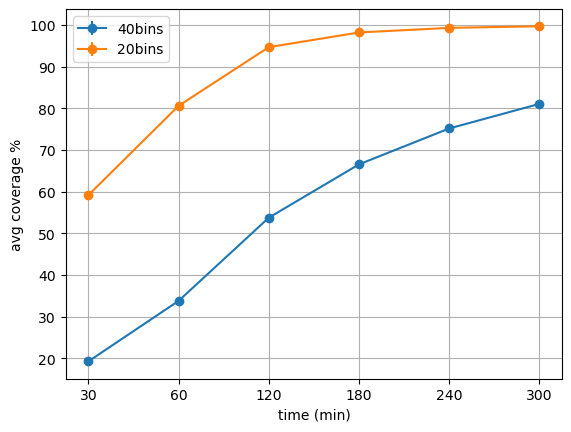

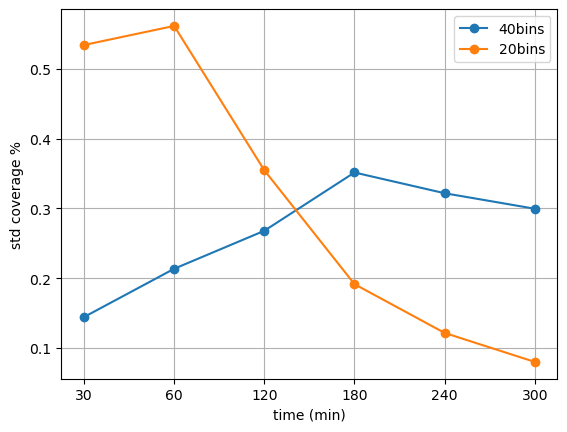

In [31]:
plt.errorbar(range(x), avgs, stds, fmt='o-', label='40bins')
plt.errorbar(range(x), avgs_s, stds_s, fmt='o-', label='20bins')
plt.grid()
plt.ylabel('avg coverage %')
plt.xlabel('time (min)')
plt.xticks(range(x), minutes)
plt.legend()
plt.show()
plt.plot(stds, 'o-', label='40bins')
plt.plot(stds_s, 'o-', label='20bins')
plt.ylabel('std coverage %')
plt.xlabel('time (min)')
plt.xticks(range(x), minutes)
plt.grid()
plt.legend()
plt.show()

In [26]:
stds

array([0.1710213 , 0.2097402 , 0.28858556, 0.32844118])